In [ ]:
import os
import sys
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.datasets as dset

from tqdm import tqdm
from sklearn.metrics import confusion_matrix


using_platform = 'kaggle'

dataset_path = None
if using_platform == 'colab':
    from google.colab import drive
    import kagglehub
    drive.mount('/content/drive')
    sys.path.append('/content/drive/My Drive/COMP4471/Project')
    dataset_path = kagglehub.dataset_download("jagachau/weather-dataset")
    dataset_path = os.path.join(dataset_path, 'weather_dataset')
elif using_platform == 'kaggle':
    dataset_path = '/kaggle/input/weather-dataset/weather_dataset'
else:
    print('invalid platform')

print('dataset path:', dataset_path)

seed = 4471
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# For precise error position
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)
print('GPU count:', torch.cuda.device_count())

dataset path: /kaggle/input/weather-dataset/weather_dataset
using device: cuda
GPU count: 1


In [14]:
grouped_dict = {
    'foggy': ['fogsmog', 'sandstorm'],
    'cold': ['snow', 'rime', 'frost', 'glaze'],
    'cloudy': ['cloudy'],
    'dew': ['dew'],
    'hail': ['hail'],
    'lightning': ['lightning'],
    'rain': ['rain'],
    'shine': ['shine'],
    'sunrise': ['sunrise']
}

all_classes = ['cloudy', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rime', 'sandstorm', 'shine', 'snow', 'sunrise']
grouped_classes = list(grouped_dict.keys())
cold_classes = ['frost', 'glaze', 'rime', 'snow']
foggy_classes = ['fogsmog', 'sandstorm']

grouped_model = torch.load('/kaggle/input/weather_models/pytorch/default/2/hierarchical_model.pth', map_location=device, weights_only=False)
foggy_model = torch.load('/kaggle/input/weather_models/pytorch/default/2/foggy_model_9419.pth', map_location=device, weights_only=False)
cold_model = torch.load('/kaggle/input/weather_models/pytorch/default/2/cold_model.pth', map_location=device, weights_only=False)

grouped_model.eval()
foggy_model.eval()
cold_model.eval()

print("Models loaded!")

Models loaded!


In [ ]:
class GroupedDataset(Dataset):
    def __init__(self, original_dataset, grouped_targets, grouped_dict):
        self.dataset = original_dataset
        self.targets = grouped_targets
        self.classes = grouped_dict

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Get the image and ignore the original label
        target = self.targets[idx]  # Use the grouped label
        return img, target

# Map original classes to grouped classes
def map_to_grouped_class(label, class_to_group):
    for group, original_classes in class_to_group.items():
        if label in original_classes:
            return group
    return label

# Create a new dataset with grouped labels
def create_grouped_dataset(dataset, class_to_group):
    grouped_targets = [
        map_to_grouped_class(dataset.classes[label], class_to_group) for label in dataset.targets
    ]
    grouped_dict = list(class_to_group.keys())
    grouped_class_to_idx = {cls: idx for idx, cls in enumerate(grouped_dict)}
    grouped_targets = [grouped_class_to_idx[label] for label in grouped_targets]
    return GroupedDataset(dataset, grouped_targets, grouped_dict)

def inference(grouped_model, foggy_model, cold_model, loader):
    correct = 0
    total = 0

    # Create mappings for later use
    original_dataset = loader.dataset.dataset 
    original_classes = original_dataset.classes

    with torch.no_grad():
        batch_idx = 0
        for inputs, grouped_labels in tqdm(loader, desc='Inference'):
            inputs, grouped_labels = inputs.to(device), grouped_labels.to(device)
            batch_size = inputs.size(0)
            total += batch_size

            # First-layer predictions
            first_outputs = grouped_model(inputs)
            first_probs = torch.softmax(first_outputs, dim=1)
            first_preds = torch.argmax(first_probs, dim=1)

            for i in range(batch_size):
                idx = batch_idx * loader.batch_size + i
                if idx >= len(original_dataset):
                    continue

                _, original_label_idx = original_dataset.samples[idx]
                original_class = original_classes[original_label_idx]

                first_pred = first_preds[i].item()

                final_prediction = None
                if first_pred == 0:  # foggy
                    second_outputs = foggy_model(inputs[i].unsqueeze(0))
                    prob = torch.sigmoid(second_outputs).item()
                    if prob > 0.5:
                        final_prediction = 'sandstorm'
                    else:
                        final_prediction = 'fogsmog'

                elif first_pred == 1:  # cold
                    second_outputs = cold_model(inputs[i].unsqueeze(0))
                    second_probs = torch.softmax(second_outputs, dim=1)
                    second_pred = torch.argmax(second_probs, dim=1).item()
                    final_prediction = cold_classes[second_pred]

                else:  # Direct classes
                    final_prediction = grouped_classes[first_pred]

                if final_prediction == original_class:
                    correct += 1

            batch_idx += 1

    accuracy = 100 * correct / total
    print(f"Overall Accuracy: {correct}/{total} = {accuracy:.2f}%")

def predict_image(tensor):
    with torch.no_grad():
        first_output = grouped_model(tensor)
        prob = torch.softmax(first_output, dim=1)
        _, predicted_idx = torch.max(prob, 1)
        predicted = grouped_classes[predicted_idx.item()]

    print(f"Predicted class: {predicted}")

    second_output = None
    if predicted_idx == 0:  # foggy
        second_output = foggy_model(tensor)
        prob = torch.sigmoid(second_output).item()
        
        if prob > 0.5:
            predicted2 = 'sandstorm'
            confidence_score = prob * 100
        else:
            predicted2 = 'fogsmog'
            confidence_score = (1.0 - prob) * 100
        
    elif predicted_idx == 1:  # cold
        second_output = cold_model(tensor)
        prob = torch.softmax(second_output, dim=1)
        confidence2, predicted_idx2 = torch.max(prob, 1)
        predicted2 = cold_classes[predicted_idx2.item()]
        confidence_score = confidence2.item() * 100
        print(f"Predicted second class: {predicted2}")
        print(f"Confidence score: {confidence_score:.2f}%")

def get_predictions_and_probs(grouped_model, foggy_model, cold_model, loader):
    grouped_model.eval()
    foggy_model.eval()
    cold_model.eval()

    group_idx_to_classes = {
        0: foggy_classes,  # foggy -> ['fogsmog', 'sandstorm']
        1: cold_classes,   # cold -> ['frost', 'glaze', 'rime', 'snow']
        2: ['cloudy'],    
        3: ['dew'],       
        4: ['hail'],      
        5: ['lightning'], 
        6: ['rain'],      
        7: ['shine'],     
        8: ['sunrise']    
    }

    all_true_labels = all_pred_labels = all_probs= []
    
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}

    original_dataset = loader.dataset.dataset

    with torch.no_grad():
        batch_idx = 0
        for inputs, grouped_labels in tqdm(loader, desc="Evaluating hierarchical model"):
            inputs = inputs.to(device)
            batch_size = inputs.size(0)

            for i in range(batch_size):
                idx = batch_idx * loader.batch_size + i
                if idx >= len(original_dataset):
                    continue

                _, original_label = original_dataset.samples[idx]
                true_class = original_dataset.classes[original_label]
                all_true_labels.append(class_to_idx[true_class])

            # First layer prediction
            first_outputs = grouped_model(inputs)
            first_probs = torch.softmax(first_outputs, dim=1)
            first_preds = torch.argmax(first_probs, dim=1)

            for i in range(batch_size):
                if (batch_idx * loader.batch_size + i) >= len(original_dataset):
                    continue

                pred_group = first_preds[i].item()

                img_probs = np.zeros(len(all_classes))

                if pred_group == 0:  # foggy
                    second_outputs = foggy_model(inputs[i].unsqueeze(0))
                    fog_prob = torch.sigmoid(second_outputs).item()
                    storm_prob = 1.0 - fog_prob
                    
                    if fog_prob > 0.5:
                        pred_class = 'sandstorm'
                    else:
                        pred_class = 'fogsmog'
                    
                    img_probs[class_to_idx['sandstorm']] = fog_prob * first_probs[i, 0].item()
                    img_probs[class_to_idx['fogsmog']] = storm_prob * first_probs[i, 0].item()

                elif pred_group == 1:  # cold
                    second_outputs = cold_model(inputs[i].unsqueeze(0))
                    second_probs = torch.softmax(second_outputs, dim=1)
                    second_pred = torch.argmax(second_probs, dim=1).item()

                    pred_class = cold_classes[second_pred]

                    for j, cls in enumerate(cold_classes):
                        img_probs[class_to_idx[cls]] = second_probs[0, j].item() * first_probs[i, 1].item()

                else:  # Direct classes
                    pred_class = group_idx_to_classes[pred_group][0]
                    img_probs[class_to_idx[pred_class]] = first_probs[i, pred_group].item()

                all_pred_labels.append(class_to_idx[pred_class])
                all_probs.append(img_probs)

            batch_idx += 1

    return np.array(all_true_labels), np.array(all_pred_labels), np.array(all_probs)

In [ ]:
resnet_mean = [0.485, 0.456, 0.406]
resnet_sd = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

dataset = dset.ImageFolder(root=dataset_path, transform=transform)
dataset = create_grouped_dataset(dataset, grouped_dict)
print(dataset.classes)

dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

['foggy', 'cold', 'cloudy', 'dew', 'hail', 'lightning', 'rain', 'shine', 'sunrise']


In [26]:
inference(grouped_model, foggy_model, cold_model, dataloader)

Inference: 100%|██████████| 125/125 [03:04<00:00,  1.47s/it]

Overall Accuracy: 7108/7987 = 88.99%


In [29]:
labels, preds, probs = get_predictions_and_probs(grouped_model, foggy_model, cold_model, dataloader)

Evaluating hierarchical model: 100%|██████████| 125/125 [03:03<00:00,  1.47s/it]


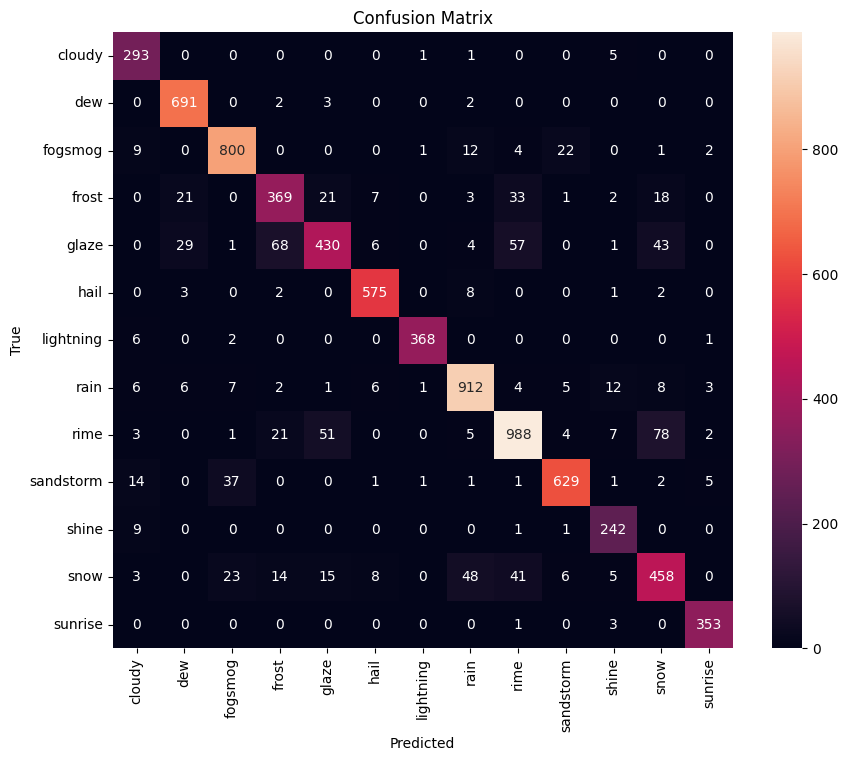

In [30]:
# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()